# ATIVIDADE PONTUADA 2
Aluno: Davi Araújo do Nascimento\
Matrícula: 202300027801

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.signal import convolve2d
import timeit

In [2]:
def printIntervalo(imagem: np.ndarray) -> None:
    min = imagem.min()
    max = imagem.max()
    
    print(f"[{min}, {max}] ({type(max).__name__})")

Antes de resolver as questões aqui está o imagem da lena conforme pedido na especificação da atividade pontuada 2.\
Pego a imagem da Lena e imprimo os seus atributos.\

In [3]:
lena_original = imread("lena_gray.bmp")

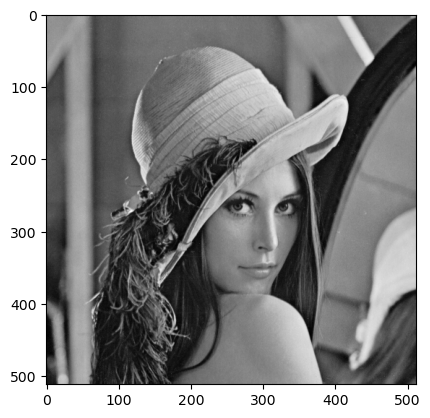

In [4]:
plt.imshow(lena_original, cmap="gray")

In [5]:
printIntervalo(lena_original)

[34, 247] (uint8)


In [6]:
lena_original.shape

(512, 512)

## Questão 1
Começo a primeira questão definindo algumas funções que me ajudarão a fazer o que é pedido, em seguida começo a usá-las.\
As células contém explicações sobre as funções e decisões que tomei.

In [7]:
# Função que calcula e retorna o valor da função da distribuição de gauss para um determinado valor x e sigma(desvio padrão)
# Usei como base a formula presente no seguinte artigo: https://en.wikipedia.org/wiki/Gaussian_blur

def gauss(x: np.float64, sigma: np.float64) -> np.float64:
    a = np.sqrt(np.pi * 2) * sigma
    b = -(x ** 2) / (2 * sigma ** 2)

    return np.exp(b) / a

In [8]:
# Função que gera e retorna o filtro passa-baixas unidimensional como vetor coluna para ser aplicado numa imagem
# O filtro retornado é do tipo Gaussian Blur
# Seu único parâmetro é a dimensão do máscara 

def gerarFiltro1d(dim: np.int32) -> np.ndarray:
    filtro = np.ndarray((dim, 1))
    
    # Utilizei esse artifício para calcular o valor de sigma baseado na dimensão
    # Depois de muita pesquisa percebi que o sigma é um valor que compõe uma relação com a dimensão da máscara
    # Geralmente se usa o sigma para calcular o tamanho da máscara, e não o contrário, como está aqui. Mas como foi pedido na especifição da atividade, o parâmetro é a dimensão
    # Tire essa fórmula de um comentário do usuário Operator77 no Stack Overflow. Ela faz sentido com a fórmula presente no artigo da Wikipedia mencionado na célula de cima
    # https://stackoverflow.com/a/62002971
    sigma = (dim - 1) / 6 
    shift = dim // 2

    for i in range(-shift, dim - shift):
        filtro[i + shift] = gauss(i, sigma)

    return filtro

Com as funções explicadas e definidas vamos agora para a aplicação dos filtros que podem ser gerados.

In [9]:
dimensao_alta  = 25 # 25 como pedido na especifição da atividade

filtro_1d_coluna = gerarFiltro1d(dimensao_alta)
filtro_1d_linha  = filtro_1d_coluna.transpose()
filtro_2d        = filtro_1d_coluna * filtro_1d_linha

Nas duas células abaixo farei as convoluções e farei o benchmark de cada célula.\
Cada célular será executada 10 vezes e uma média do tempo será feita, tudo isso utilizando da função mágica ```%%timeit```.\
Vale notar que com as convoluções farão a imagem sair do formato matriz de uint8 para float64.

In [10]:
%%timeit -r 10

# Aqui estou usando a separabilidade e aplicando primeiro o filtro nas colunas e depois linhas
# Perceba que estou usando o argumento wrap nas funções de convolução. 
# Ele serve para usar os pixels do lado oposto da imagem no cálculo para evitar a formação de uma borda preta na imagem filtrada
lena_filtro_1d_coluna = convolve2d(lena_original, filtro_1d_coluna, "same", "wrap")
lena_filtro_1d_ambos  = convolve2d(lena_filtro_1d_coluna, filtro_1d_linha, "same", "wrap")

46.6 ms ± 465 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [11]:
%%timeit -r 10

# Aqui o filtro 2d é aplicado inteiro de uma vez 
lena_filtro_2d = convolve2d(lena_original, filtro_2d, "same", "wrap")

212 ms ± 2.01 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


É possível notar uma diferença enorme entre os tempos de execução de cada célula, um pouco mais de 4 vezes a duração do tempo de execução.\
Minha hipótese é que o algoritmo para convolução com matriz tem uma ordem maior na sua complexidade do que quando comparado com a convolução com vetor.\
Com o benchmark feito, irei mostrar as imagens geradas.

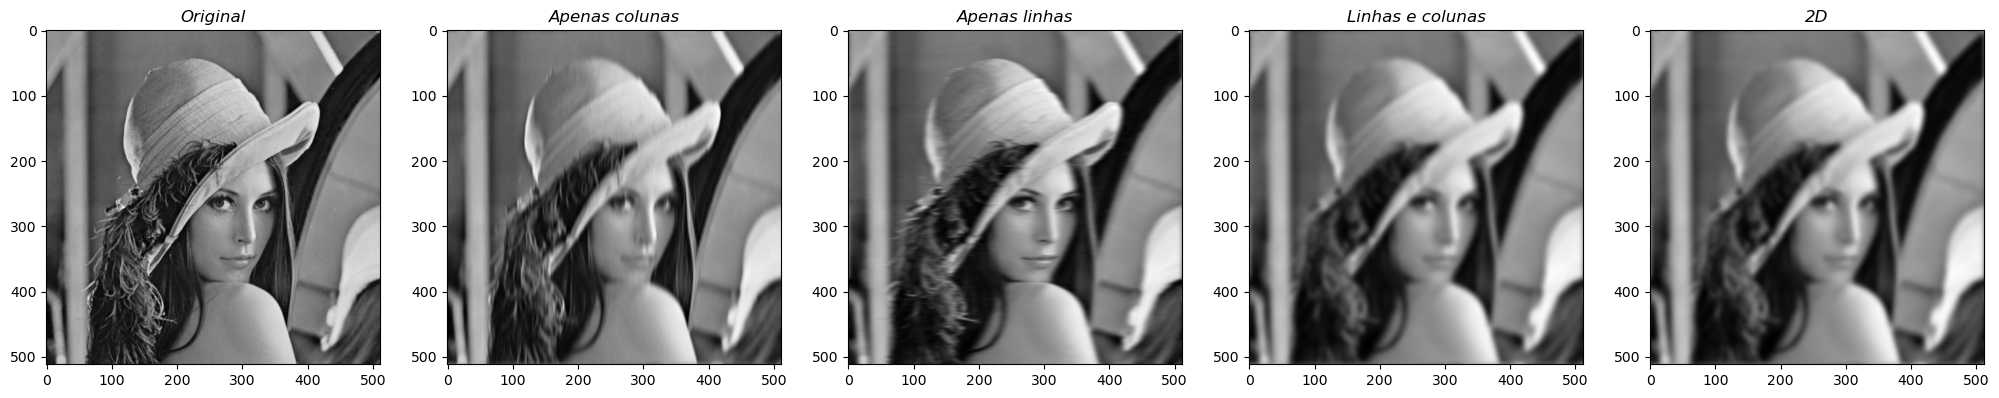

In [12]:
# Para comparação e curiosidade minha, também vou imprimir a imagem com apenas o filtro linha aplicado
# Por causa de alguns problemas envolvendo o escopo das variavéis nas células com %%timeit preciso fazer a convolução denovo fora do escopo
lena_filtro_1d_coluna = convolve2d(lena_original, filtro_1d_coluna, "same", "wrap")
lena_filtro_1d_linha  = convolve2d(lena_original, filtro_1d_linha, "same", "wrap")
lena_filtro_1d_ambos  = convolve2d(lena_filtro_1d_coluna, filtro_1d_linha, "same", "wrap")
lena_filtro_2d        = convolve2d(lena_original, filtro_2d, "same", "wrap")

_, sp0 = plt.subplots(1, 5, figsize=(25,25))

sp0[0].set_title("Original", fontstyle="italic")
sp0[0].imshow(lena_original, cmap="gray")

sp0[1].set_title("Apenas colunas", fontstyle="italic")
sp0[1].imshow(lena_filtro_1d_coluna, cmap="gray")

sp0[2].set_title("Apenas linhas", fontstyle="italic")
sp0[2].imshow(lena_filtro_1d_linha, cmap="gray")

sp0[3].set_title("Linhas e colunas", fontstyle="italic")
sp0[3].imshow(lena_filtro_1d_ambos, cmap="gray")

sp0[4].set_title("2D", fontstyle="italic")
sp0[4].imshow(lena_filtro_2d, cmap="gray")

## Questão 2
Aqui defino agora mais algumas funções que ajudarão a fazer esta questão.

In [13]:
# Função que gera e retorna um filtro passa-baixas bidimensional se aproveitando da separabilidade da função gaussiana
# O filtro retornado é do tipo Gaussian Blur
# O seu único parâmetro é a dimensão da máscara

def gerarFiltro2d(dim: np.int32) -> np.ndarray:
    coluna = gerarFiltro1d(dim)
    linha = coluna.transpose()
            
    return coluna * linha

In [14]:
# Função que gera e retorna um filtro bidimensional passa-altas utilizando-se dos filtros 2d gerados pela função da célula acima
# O filtro que esta função gera é do tipo DoG(Difference of Gaussians)
# Possui dois parâmetros: as dimensões dos dois filtros que serão usados para fazer a diferença

def gerarDoG(dim_a: np.int32, dim_b: np.int32):
    # Faço um tratamento do tamanho da matriz de menor tamanho, aumentando sua dimensão para combinar com a matriz maior
    # Adiciono 0 nos espaços novos que surgiram na matriz anteriormente menor
    if dim_a > dim_b:
        maior = gerarFiltro2d(dim_a)
        menor = gerarFiltro2d(dim_b)
    else:
        menor = gerarFiltro2d(dim_a)
        maior = gerarFiltro2d(dim_b)

    # Calculo o tamanho do pad para ser criado
    pad_size = (maior.shape[0] - menor.shape[0]) // 2
    menor = np.pad(menor, ((pad_size, pad_size),(pad_size, pad_size)), "constant", constant_values = 0)

    return menor - maior

Aqui entrou um ponto de confusão para mim. Pelo que entendi da atividade, eu preciso primeiro gerar o filtro para depois aplicá-lo, no entanto,\
eu não encontrei um procedimento para que eu entendesse como isso poderia ser feito. Apenas achei que esse filtro é implementado aplicando o filtro normal a duas cópias distintas da imagen e subtraindo-as,\
o que creio que não é o que está sendo pedido na especificação da atividade. Portanto, farei das duas formas, uma gerando a máscara a partir de outras duas e uma onde as imagens são geradas primeiro para depois subtrair uma da outra.\
Explicarei cada uma e também tirarei algumas conclusões sobre a diferença entre os dois métodos.

### Subtração de máscaras:

Creio que esse seja o método desejado. Nele eu crio uma matriz A de dimensão N x N e outra B de dimensão M x M, onde N > M.\
Como não é possível subtrair uma matriz por outra de dimensões diferentes, eu envolvo B em 0s até que ela fique do mesmo tamanho de A e então faço a subtração.\
Não sei se essa é a forma correta de executar essa operação, visto que não encontrei muita coisa na internet sobre. Minha única referência é essa discussão no [Stack Exchange](https://dsp.stackexchange.com/questions/86094/analyzing-2-2d-kernels-which-approximates-a-gaussian-kernel).

In [15]:
# Escolhi um outro valor para a dimensão baixa no cálculo da filtro DoG
# Lembrando que a dimensão alta ainda é 25
dimensao_baixa = 9  

print(f"Dimensão alta: {dimensao_alta}")

Dimensão alta: 25


In [16]:
filtro_dog       = gerarDoG(25, 9)
lena_dog_mascara = convolve2d(lena_original, filtro_dog, "same", "wrap")

### Subtração de imagens:
Este método é mais simples que o anterior, apenas aplico os dois filtros em duas cópias da imagem e subtraio-as. Esse foi o método que vi sendo comentado na internet.\
Como já disse, acho que esse não é o método que está sendo pedido na especificação da atividade, mas quis fazer para ter as duas opções presentes no notebook.

In [17]:
filtro_2d_alto  = gerarFiltro2d(25)
filtro_2d_baixo = gerarFiltro2d(9)

lena_filtro_2d_alto  = convolve2d(lena_original, filtro_2d_alto, "same", "wrap")
lena_filtro_2d_baixo = convolve2d(lena_original, filtro_2d_baixo, "same", "wrap")

lena_dog_imagem = lena_filtro_2d_baixo - lena_filtro_2d_alto

### Diferenças

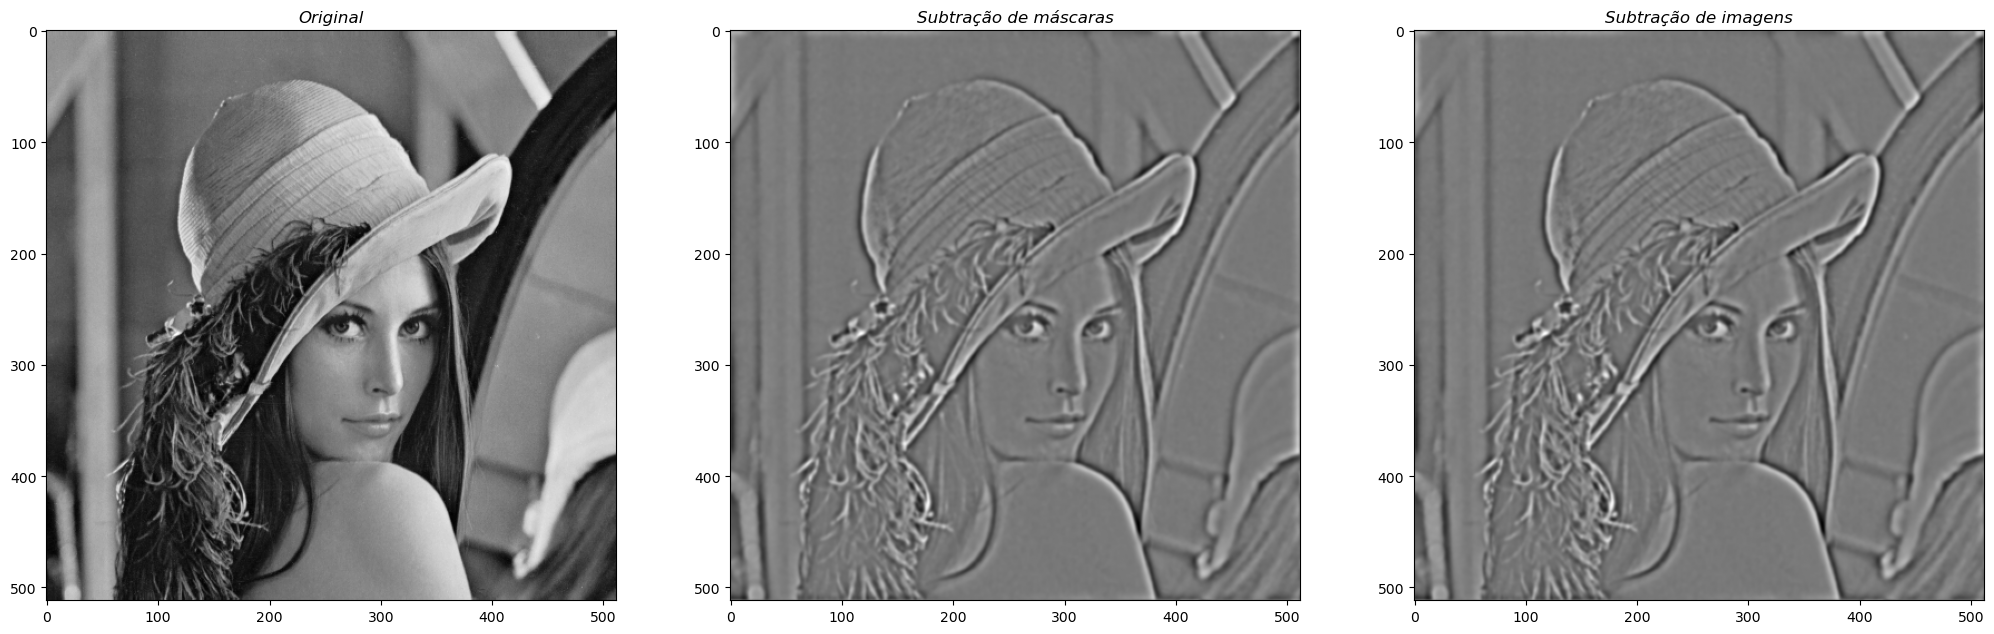

In [18]:
_, sp1 = plt.subplots(1, 3, figsize=(25,25))

sp1[0].set_title("Original", fontstyle="italic")
sp1[0].imshow(lena_original, cmap="gray")

sp1[1].set_title("Subtração de máscaras", fontstyle="italic")
sp1[1].imshow(lena_dog_mascara, cmap="gray")

sp1[2].set_title("Subtração de imagens", fontstyle="italic")
sp1[2].imshow(lena_dog_imagem, cmap="gray")

Comparando as duas imagens vejo que, visualmente, elas não têm muitas diferenças entre si. Apenas percebo que elas têm uma tonalidade um pouco diferente, mas é só isso.\
Porém, pelo menos, as propriedades de filtro passa-altas se mantêm.

Talvez nos histogramas ou mínimo e máximo algo mude.

In [19]:
print("Original")
printIntervalo(lena_original)

print("\nSubtração de máscaras")
printIntervalo(lena_dog_mascara)

print("\nSubtração de imagens")
printIntervalo(lena_dog_imagem)

Original
[34, 247] (uint8)

Subtração de máscaras
[-60.37316707910304, 68.1652301610252] (float64)

Subtração de imagens
[-60.37316707910303, 68.16523016102508] (float64)


Muito, muito parecido. Vamos ver os histogramas.

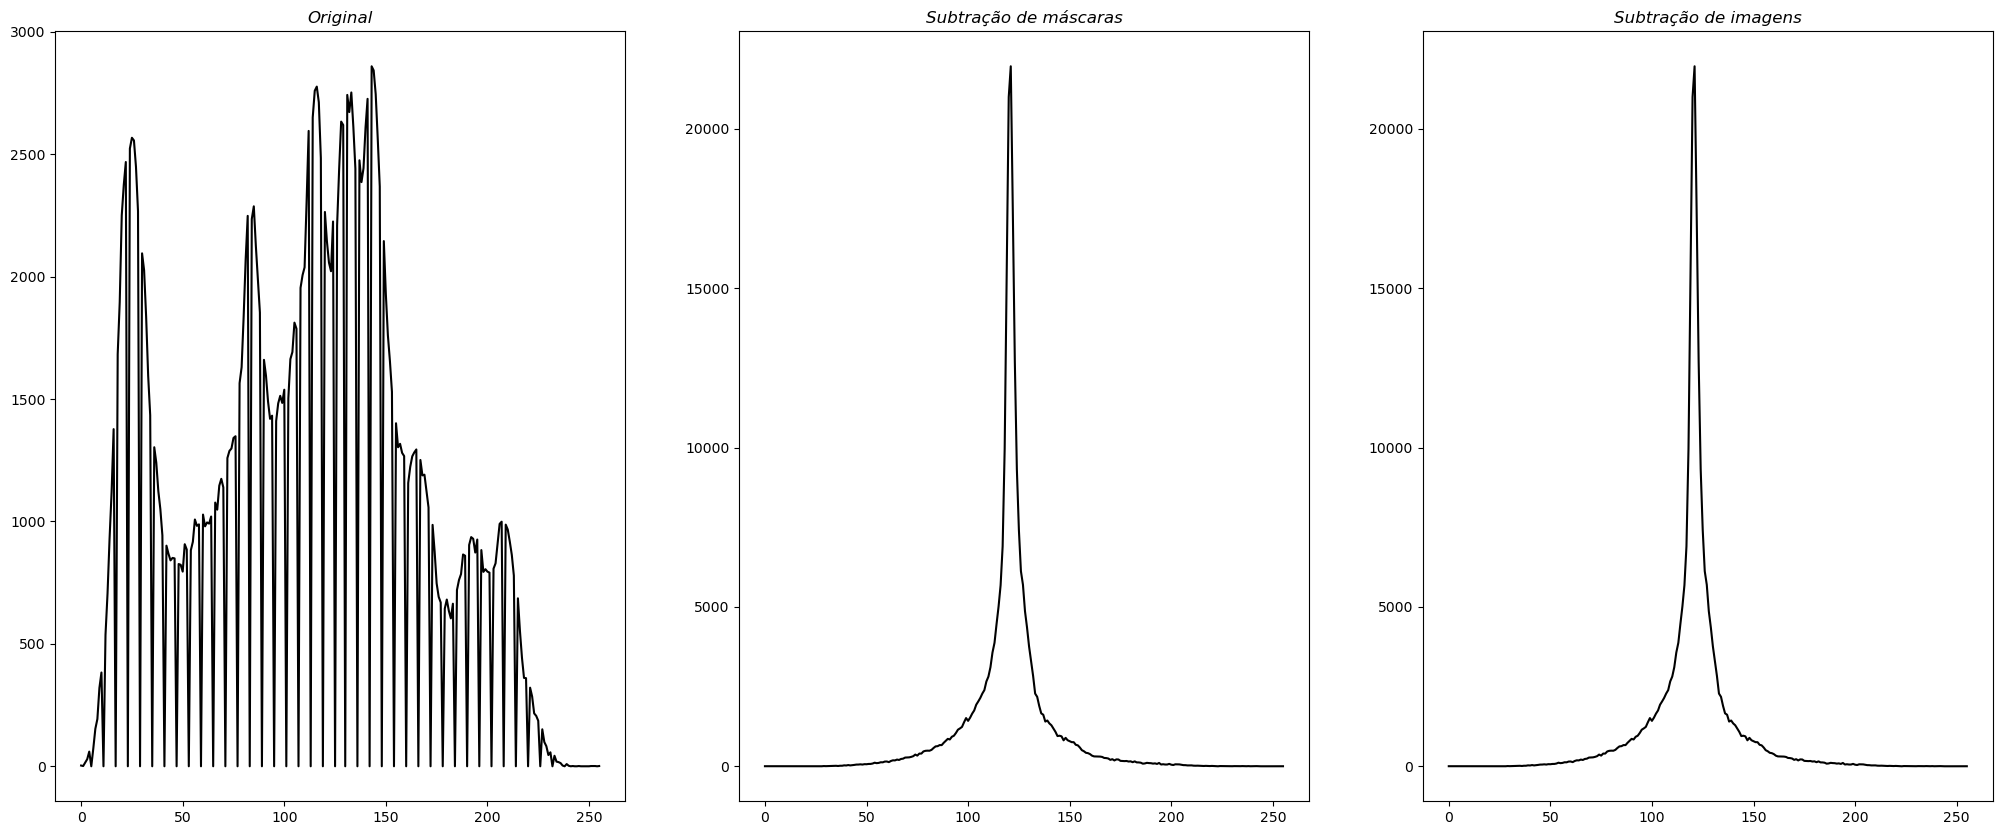

In [20]:
hist_original, _ = np.histogram(lena_original, bins=256) 
hist_mascara,  _ = np.histogram(lena_dog_mascara, bins=256) 
hist_imagens,  _ = np.histogram(lena_dog_imagem, bins=256)

_, sp2 = plt.subplots(1, 3, figsize=(25, 10))

sp2[0].set_title("Original", fontstyle="italic")
sp2[0].plot(hist_original, '-k')

sp2[1].set_title("Subtração de máscaras", fontstyle="italic")
sp2[1].plot(hist_mascara, '-k')

sp2[2].set_title("Subtração de imagens", fontstyle="italic")
sp2[2].plot(hist_imagens, '-k')

Aqui também os métodos se mostram bem parecidos

### Conclusão

Minha conclusão disso tudo é que essas duas formas de aplicar a diferença de gaussianas são muito parecidas.\
Não posso afirmar que são equivalentes ou iguais porque isso requereria uma prova matemática.\
Para fim de testes e experimentação foi muito legal ver as duas formas que pareciam diferentes no começo tendo praticamente o mesmo efeito na imagem.\
Isso me afirmou que esse método de calcular a máscara da DoG que "inventei" não está tão longe de ser como realmente é feito. Coisa que me deu mais confiança sobre a minha resposta. 